# Covid19 Data Visualization

### ToDo
1. Add cumulative & population adjustment options to cases vs deaths graph (need to make additions in preprocessing for those fields)
1. Add date aggregation option

### Overview
...

In [2]:
import os
import re
import json
import datetime
from math import ceil
from io import StringIO
from glob import glob
# aws
#import boto3
# quant analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm
# import sklearn.datasets
# import scipy.stats
# data viz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
# import seaborn as sns
# import bokeh

In [3]:
### itertools permutations combination of 2 lists ###
# from itertools import permutations
# l1 = cases.FIPS.unique().tolist()
# l2 = cases.RECORD_DT.map(lambda t: t.date()).unique().tolist()
# pairs = [] 
# permuts = permutations(l1, len(l2))
# for comb in permuts: 
#     zipped = zip(comb, l2) 
#     pairs.append(list(zipped)) 

In [4]:
def CONFIG():
    """"""
    pid = 'analysis-covid19'
    now = datetime.datetime.now()
    cwd = os.getcwd()
    data = os.path.join(cwd,'out')
    
    cfg = {
        'out': data,
        'covid': os.path.join(data,'covid'),
        'demo': os.path.join(data,'demo'),
        'files': glob(os.path.join(data,'*','*.parquet.gzip'),recursive=True),
    }
    
    return cfg

In [5]:
class Covid19: # naming convention: GoodName
    """
    Class for retrival, storage, and manipulation
      of Covid19 data.
    """
    
    __slots__ = ('fpath','dataframe',)
    
    def __init__(self,fpath):
        self.fpath = fpath
        self.dataframe = _load()
        self.is_clean = 0
        self.is_processed = 0
    
    @staticmethod # static methods - does it make sense to call a class method
    # EVEN BEFORE a class has been created? e.g. metric conversion info
    def define():
        return """Class for handling Covid19 data and analysis."""
    
    def __repr__(self):
        return f'Covid19({self.fpath!r})'
    def __str__(self):
        return f'Covid19 dataset - {self.fpath}'
    def _load(self):
        return pd.read_parquet(self.fpath,header=0)
    
    # instance method
    def clean(self):
        try:
            df = self.dataframe
            # ...
            self.dataframe = df
            self.is_clean = 1
        except:
            raise
    
    # instance method
    def process(self):
        try:
            assert self.is_clean==1
            df = self.dataframe
            # ...
            self.dataframe = df
            self.is_processed = 1
        except AssertionError:
            self.clean()
            self.process()
        except:
            raise
    

In [6]:
def SUMMARY(series, sample=2):
    """"""
    unique = series.unique()
    values = series.dropna()
    dtype = str(type(values[0])).split('\'')[1]
    
    return {
        'dtype': dtype, # c.dtypes
        'sample': series.sample(n=sample).to_list(), # .sample(n=ceil(series.shape[0]*sample)),
        'countA': series.shape[0],
        'countD': len(unique),
        'countV': series.count(),
        'countNaN': series.isna().sum(),
        'min': min(values),
        'mode': series.mode().to_list(),
        'max': max(values),
        'median': series.median() if dtype!='str' else None,
        'mean': round(series.mean(),2) if dtype!='str' else None,
        'std': round(series.std(),2) if dtype!='str' else None,
    }

In [16]:
def CASES_VS_DEATHS(df,states,adj=False,cum=True,strt_dt=datetime.datetime(2020,3,1),end_dt=datetime.datetime.now(),agg='daily'):
    """
    df = (pd.DataFrame) Covid19 US time series data from JHU
    states = (list) list of states - max of 3
    adj = (bool) adjustment for population
    cum = (bool) cumulative data (vs. daily counts)
    strt_dt = (datetime) start date
    end_dt = (datetime) end date
    """
    if agg not in ['daily','weekly','monthly','quarterly','yearly']:
        raise Exception('Unknown date aggregation period "{}".',format(agg))
    if len(states)>3:
        print('Max of 3 states allowed - trimming off the rest.')
        states = states[:3]
    # data manipulation
    df.DEATHS = df.DEATHS.astype(int)
    df.CASES = df.CASES.astype(int)
    df.POPULATION = df.CASES.astype(int)
#     df.PPL_PER_1K = (df.POPULATION/1000).astype(int) # move to preprocessing
    df = df[['RECORD_DT','PROVINCE_STATE','CASES','DEATHS','POPULATION']].loc[
        (df.PROVINCE_STATE.str.upper().isin([i.upper() for i in states]))
        & (df.RECORD_DT >= strt_dt)
        & (df.RECORD_DT <= end_dt)
    ].groupby(['RECORD_DT','PROVINCE_STATE']).agg('sum').reset_index(drop=False)
    df.RECORD_DT = df.RECORD_DT.dt.date
    # graph static info
    dtfmt = '%b %Y'
    title = 'Covid19 Cases & Deaths by State over Time'#.format(STATE = state.capitalize())
    footnote = '{STRT_DT} to {END_DT}; {ADJ} for population; {CUM}'.format(
        STRT_DT = strt_dt.strftime(dtfmt),
        END_DT = end_dt.strftime(dtfmt),
        ADJ = 'Adjusted' if adj else 'Not adjusted',
        CUM = 'Cumulative over time' if cum else 'Daily counts'
    )
    bar_width = 0.3
    alpha = 0.6
    rot = 60
    fs_title = 18
    fs_sub = 14
    fs_ax = 12
    fs_fn = 10
    fmt_dt = '%d %b'
    figsize = (20,6*len(states))
    # init
    fig, axs = plt.subplots(nrows=len(states),ncols=1,figsize=figsize, sharex=True, constrained_layout=True)
    axs = axs if len(states)>1 else [axs]
    axis = {i:{'ax1':None,'ax2':None} for i in states}
    for i,j in enumerate(states):
        axis[j]['ax1']=axs[i]
    plt.suptitle(title, fontsize=fs_title) # fontweight='bold'
    plt.grid(True)
#     plt.tight_layout()
    plt.style.use('fivethirtyeight') # ggplot, seaborn, fivethirtyeight, tableau-colorblind10, grayscale
    plt.xticks(rotation=rot)
    for state in states:
        _df = df.loc[df.PROVINCE_STATE==state.upper()]
        # axis 1 - cases
        axis[state]['ax1'].set_title(state, fontsize=fs_sub)
        axis[state]['ax1'].set_ylabel('Cases', fontsize=fs_ax)
        axis[state]['ax1'].bar(
            _df.RECORD_DT,
            _df.CASES,
            color='gray',
            label = 'Cases',
            width=bar_width,
            alpha = alpha,
        )
#         axis[state]['ax1'].tick_params(axis='y')
        axis[state]['ax1'].yaxis.grid('both',color='k', linestyle='-', alpha=0.3)
        # axis 2 - deaths
        axis[state]['ax2'] = axis[state]['ax1'].twinx()
        axis[state]['ax2'].set_ylabel('Deaths', fontsize=fs_ax)
        axis[state]['ax2'].plot(
            _df.RECORD_DT,
            _df.DEATHS,
            label = 'Deaths',
            alpha = alpha,
        #     color = 'blue',
        #     marker='o',
        )
        axis[state]['ax2'].tick_params(axis='y')

    # final touches
    axis[states[0]]['ax1'].legend(loc='upper left')
    axis[states[0]]['ax2'].legend(loc='lower right')
    axis[states[-1]]['ax1'].set_xlabel('Date', fontsize=fs_ax)
    axis[states[-1]]['ax1'].xaxis.set_major_formatter(mdates.DateFormatter(fmt_dt))
    plt.figtext(0,-0.05,footnote,fontsize=fs_fn)
    plt.show()
    # fig.savefig('covid19.svg', transparent=False, dpi=80, bbox_inches='tight')

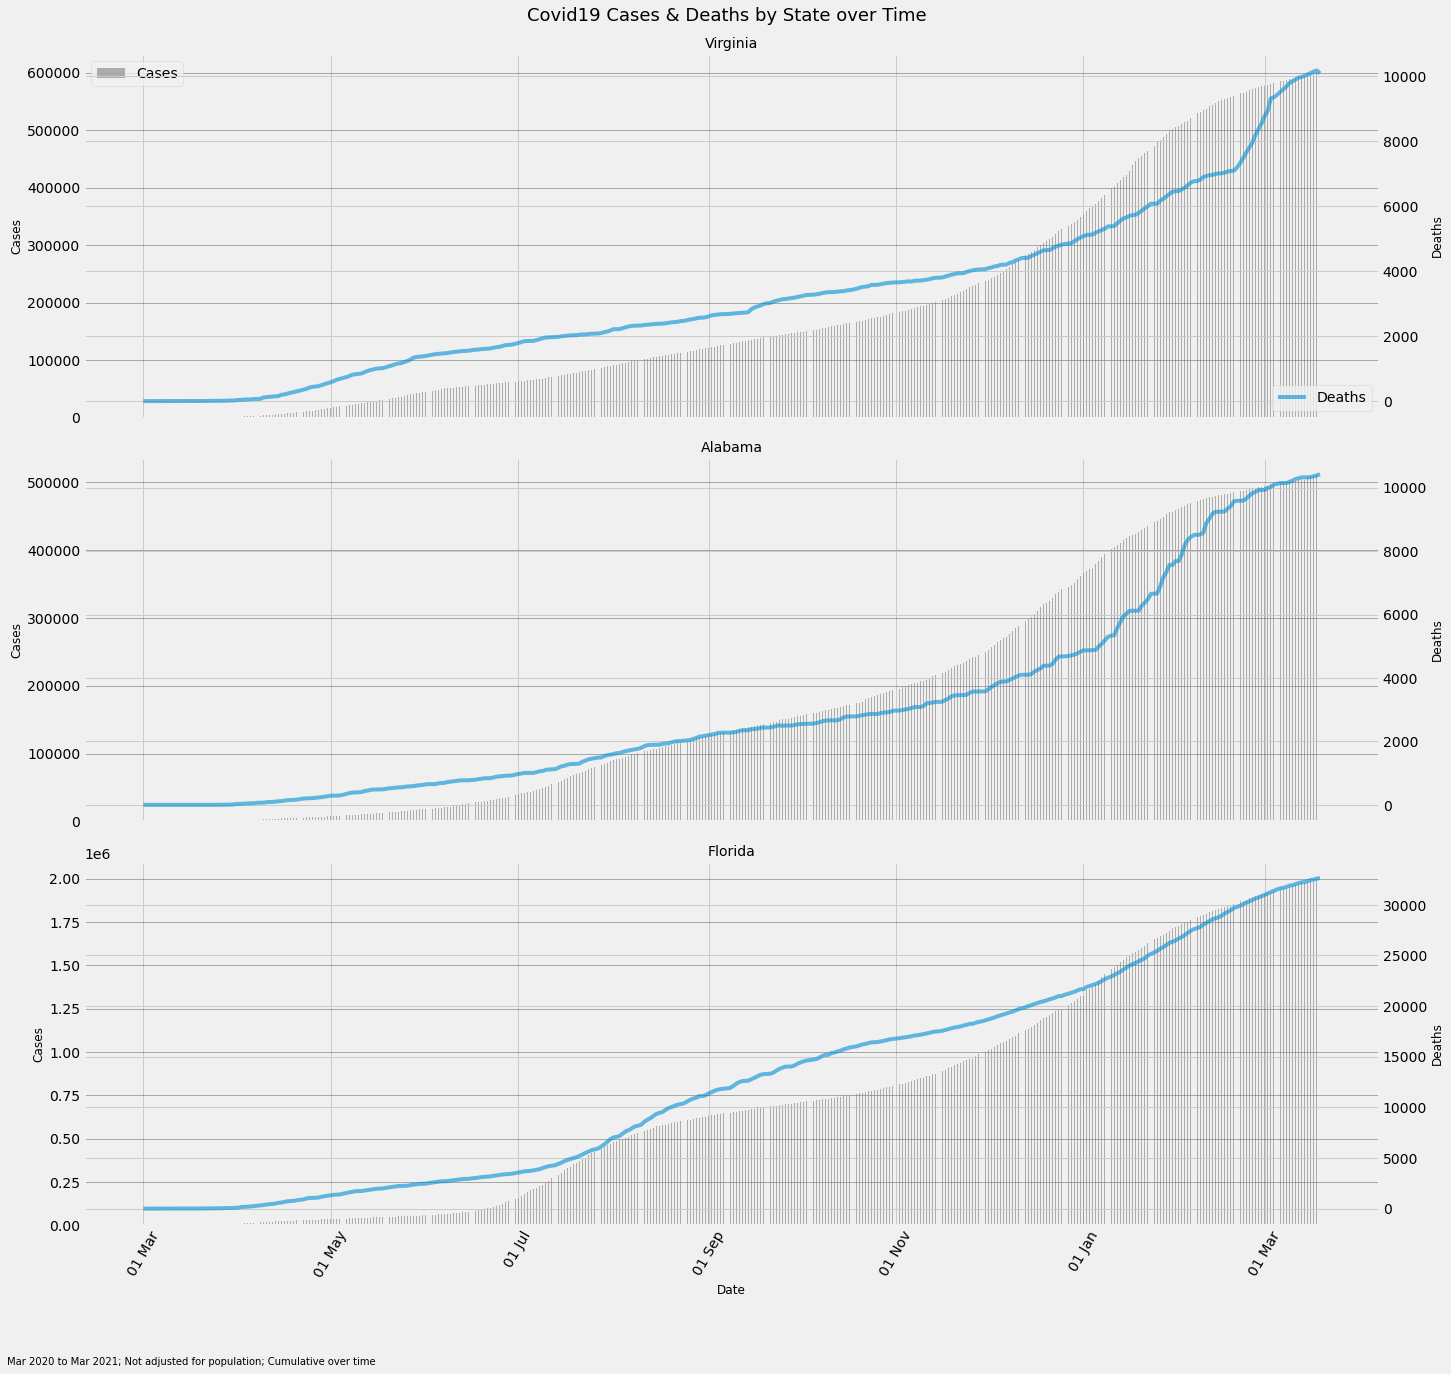

In [18]:
if __name__=='__main__':
    CFG = CONFIG()
    
    data = {}
    for file in CFG['files']:
        fname = os.path.basename(file).split('.')[0]
        data[fname] = pd.read_parquet(file)
    dt_fip_st = ['RECORD_DT','FIPS','PROVINCE_STATE']
    df = {
        'cases vs deaths': data['covid-jhu-ts-cases'][dt_fip_st+['CASES']].merge(
            data['covid-jhu-ts-deaths'][dt_fip_st+['POPULATION','DEATHS']],
            how = 'inner',
            on = ['RECORD_DT','FIPS','PROVINCE_STATE']
        )
    }
    
    CASES_VS_DEATHS(df['cases vs deaths'], ['Virginia','Alabama','Florida'])

In [8]:
# pop = data['covid-jhu-fips'][['POPULATION','PROVINCE_STATE','FIPS']].dropna() # county fips
# cases = data['covid-jhu-ts-cases'][['FIPS','RECORD_DT','CASES','CASES_CUM']].dropna() # county fips
# geo = data['demo-cb-geo'][['ALAND','GEOID']].dropna() # county fips
# pov = data['demo-cb-pov'][['ALL AGES IN POVERTY PERCENT','YEAR','COUNTY ID']].dropna() # county fips
# test = data['covid-jhu-dly-us'][['TESTING_RATE','PROVINCE_STATE']].dropna() # only state level available
# death = data['covid-jhu-ts-deaths'][['FIPS','RECORD_DT','DEATHS']].dropna() # county fips